In [7]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

In [32]:
import matplotlib.pyplot as plt

In [33]:
from pathlib import Path
# load dataset from h5
data_path = Path(r"/disk/scratch2/nkudryas/BAND-torch/datasets/BCI_train.h5")
import h5py
with h5py.File(data_path, 'r') as f:
    X = f['valid_encod_data'][:]
    Y = f['valid_behavior'][:]

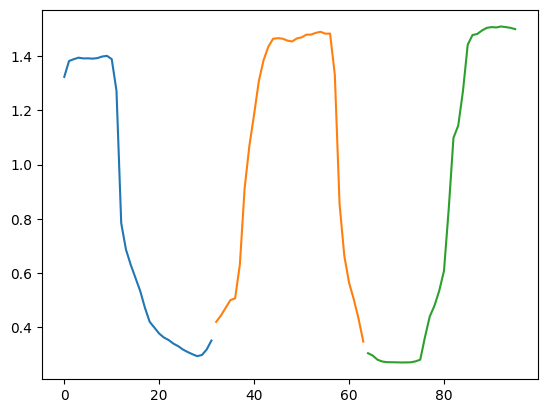

In [40]:
import numpy as np

c=2
plt.plot(np.arange(32),Y[0,:,c])
plt.plot(np.arange(32)+32,Y[1,:,c])
plt.plot(np.arange(32)+64,Y[2,:,c])


In [17]:
dataset_name = 'BCI_kaggle'
model_str = 'BCI_kaggle'
run_tag = 'single'
models_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/pbt-bci-kaggle/{dataset_name}"

fac_dim, co_dim = 100,4
bw = 0.1
encod_seq_len = 101
encod_data_dim = 207
seed = 2
model_dest = f"{models_dest}/{run_tag}"

model_dest


'/disk/scratch2/nkudryas/BAND-torch/runs/pbt-bci-kaggle/BCI_kaggle/single'

In [19]:
import torch
from hydra.utils import instantiate
from pathlib import Path
import hydra

from lfads_torch.band_utils import flatten


overrides={
        "datamodule": dataset_name,
        "model": model_str, 
    }
config_path="../../configs/pbt.yaml"
# config_path="../../configs/single.yaml"
print(config_path)

# Compose the train config with properly formatted overrides
config_path = Path(config_path)
overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
with hydra.initialize(
    config_path=config_path.parent,
    job_name="get_weights",
    version_base="1.1",
):
    config = hydra.compose(config_name=config_path.name, overrides=overrides)

# Instantiate `LightningDataModule` and `LightningModule`
datamodule = instantiate(config.datamodule, _convert_="all")
model = instantiate(config.model)

from glob import glob
checkpoint_folders = glob(model_dest+'/best_model/checkpoint*')

ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
model.load_state_dict(torch.load(ckpt_path)["state_dict"])


../../configs/pbt.yaml


<All keys matched successfully>

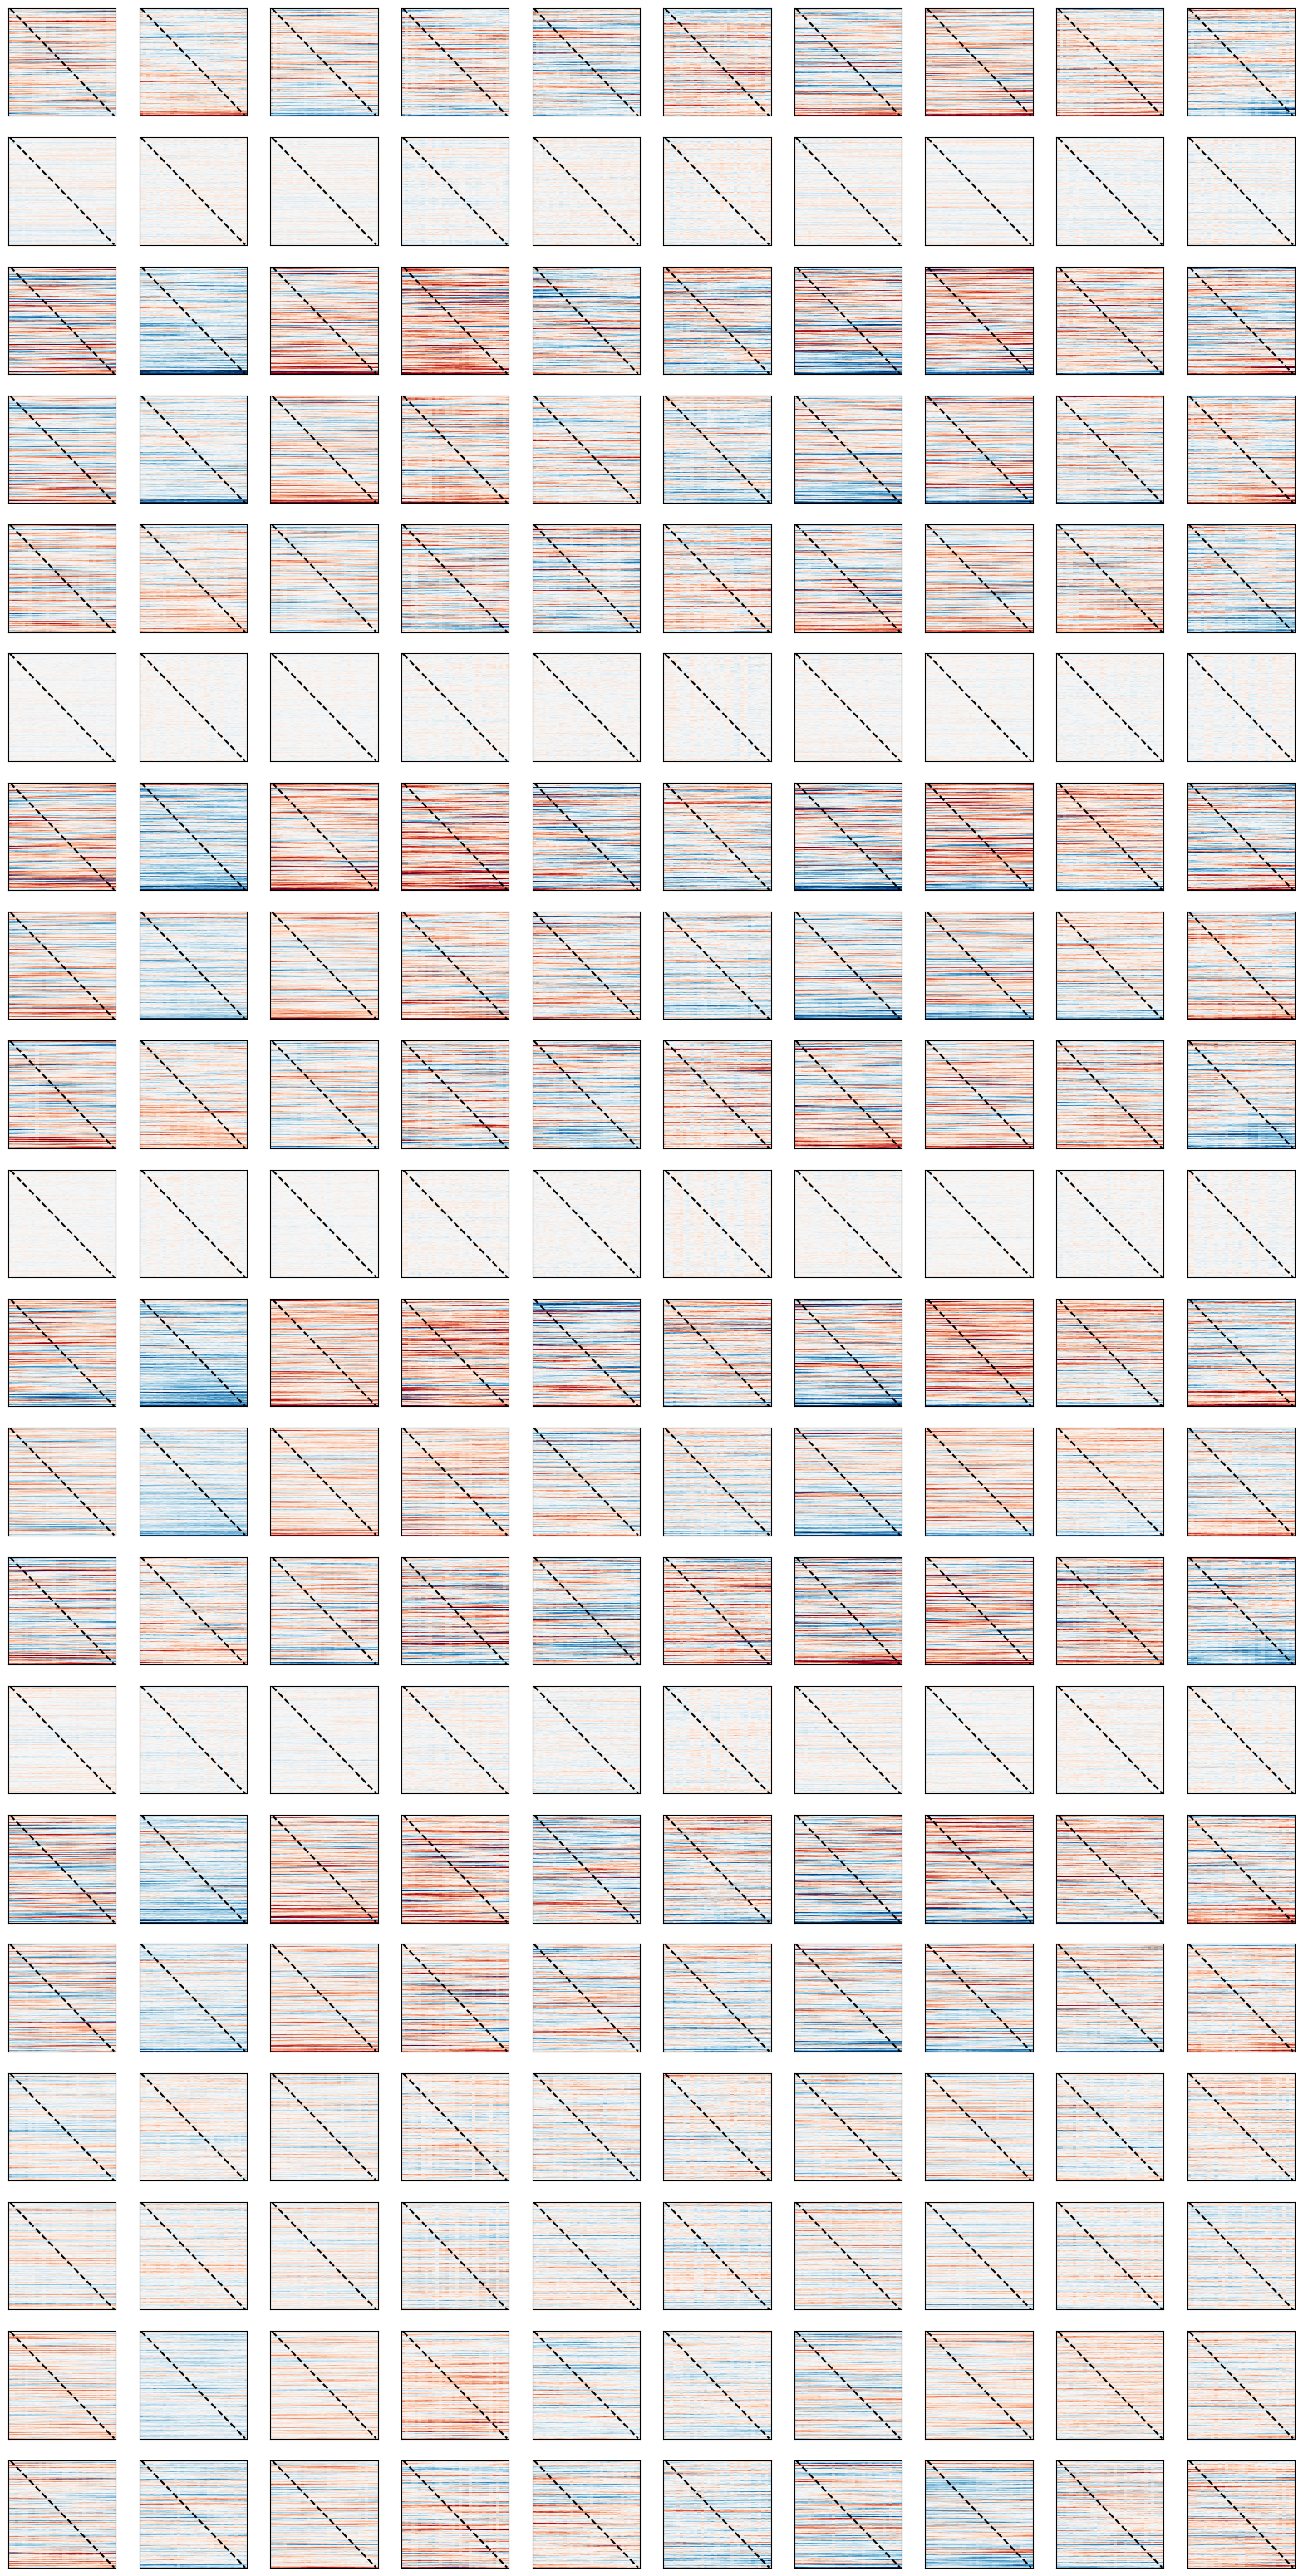

In [31]:
seq_len = config.model.recon_seq_len
bci_seq_len = config.model.behavior_readout.bci_time_features
# in_features = config.model.behavior_readout.modules[0].in_features
# out_features = config.model.behavior_readout.modules[0].out_features
# beh_W = model.behavior_readout[0].layers[1].weight.T

in_features = config.model.behavior_readout.in_features
out_features = config.model.behavior_readout.out_features
beh_W = model.behavior_readout.layers[2].weight.T

assert beh_W.shape == (in_features*seq_len, out_features*bci_seq_len)

beh_W = beh_W.reshape((seq_len, in_features, bci_seq_len, out_features))

r = torch.std(beh_W)*4
fig, ax = plt.subplots(out_features, min(in_features,10), figsize=(2*min(in_features,10), 2*out_features))
for j in range(min(in_features,10)):
    for i in range(out_features):
        ax[i,j].imshow(beh_W[:,j,:,i].detach().numpy(), cmap='RdBu', vmin=-r, vmax=r,aspect=1/8,interpolation='none')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].plot([0,bci_seq_len-1], [0, seq_len-1], 'k--')

plt.show()